In [2]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['reso'] = 'xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [3]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/pod/configs.json','r',encoding='utf-8') as f:
    CONFIGSPOD = json.load(f)
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/nn/configs.json','r',encoding='utf-8') as f:
    CONFIGSNN  = json.load(f)

FILEDIR     = CONFIGSPOD['paths']['filedir']
MODELDIRPOD = CONFIGSPOD['paths']['modeldir']
MODELDIRNN  = CONFIGSNN['paths']['modeldir']
RESULTSDIR  = CONFIGSPOD['paths']['resultsdir']
INPUTVAR    = CONFIGSPOD['dataparams']['inputvar']  
TARGETVAR   = CONFIGSPOD['dataparams']['targetvar'] 
LANDVAR     = CONFIGSPOD['dataparams']['landvar']  
LANDTHRESH  = CONFIGSPOD['dataparams']['landthresh']

BINMIN       = CONFIGSPOD['fitparams']['binmin']
BINMAX       = CONFIGSPOD['fitparams']['binmax']
BINWIDTH     = CONFIGSPOD['fitparams']['binwidth']
SAMPLETHRESH = CONFIGSPOD['fitparams']['samplethresh']
PRMIN        = CONFIGSPOD['fitparams']['prmin']
PRMAX        = CONFIGSPOD['fitparams']['prmax']

SPLIT   = 'valid'  
PODRUNS = CONFIGSPOD['runs']
NNRUNS  = CONFIGSNN['runs']

In [5]:
def load(split=SPLIT,inputvar=INPUTVAR,targetvar=TARGETVAR,landvar=LANDVAR,filedir=FILEDIR):
    filename = f'{split}.h5'
    filepath = os.path.join(filedir,filename)
    ds = xr.open_dataset(filepath,engine='h5netcdf')[[inputvar,targetvar,landvar]]
    return ds.load()

ds = load()
x  = ds[INPUTVAR].load()
lf = ds[LANDVAR].load()

In [6]:
def compute_bins(x,y,lf=None,mode='pooled',landthresh=LANDTHRESH,binmin=BINMIN,binmax=BINMAX, 
                 binwidth=BINWIDTH,samplethresh=SAMPLETHRESH,prmin=PRMIN,prmax=PRMAX):
    binedges   = np.arange(binmin,binmax+binwidth,binwidth)
    bincenters = (binedges[:-1]+binedges[1:])/2
    def ramp(xdata,ydata):
        binidxs = np.digitize(xdata,binedges)-1
        inrange = (binidxs>=0)&(binidxs<bincenters.size)
        counts  = np.bincount(binidxs[inrange],minlength=bincenters.size).astype(np.int64)
        sums    = np.bincount(binidxs[inrange],weights=ydata[inrange],minlength=bincenters.size).astype(np.float32)
        with np.errstate(divide='ignore',invalid='ignore'):
            ymeans = sums/counts
        ymeans[counts<samplethresh] = np.nan
        fitrange = np.isfinite(ymeans)&(ymeans>=prmin)&(ymeans<=prmax)
        alpha,intercept = np.polyfit(bincenters[fitrange],ymeans[fitrange],1)
        blcrit = -intercept/alpha
        return ymeans,fitrange,float(alpha),float(blcrit)
    xflat = x.values.ravel()
    yflat = y.values.ravel()
    if mode=='pooled':
        finite = np.isfinite(xflat)&np.isfinite(yflat)
        ymeans,fitrange,alpha,blcrit = ramp(xflat[finite],yflat[finite])
        return {
            'bincenters':bincenters,
            'ymeanpooled':ymeans,
            'fitrangepooled':fitrange,
            'alphapooled':alpha,
            'blcritpooled':blcrit}
    elif mode == 'regional':
        lfflat = lf.values.ravel()
        finite = np.isfinite(xflat)&np.isfinite(yflat)&np.isfinite(lfflat)
        land  = finite&(lfflat>=landthresh)
        ocean = finite&(lfflat<landthresh)
        ymeansland,fitrangeland,alphaland,blcritland     = ramp(xflat[land],yflat[land])
        ymeansocean,fitrangeocean,alphaocean,blcritocean = ramp(xflat[ocean],yflat[ocean])
        return {
            'bincenters':bincenters,
            'ymeanland':ymeansland,
            'fitrangeland':fitrangeland,
            'alphaland':alphaland,
            'blcritland':blcritland,
            'ymeanocean':ymeansocean,
            'fitrangeocean':fitrangeocean,
            'alphaocean':alphaocean,
            'blcritocean':blcritocean}

nnbins = {}
for run in NNRUNS:
    runname  = run['run_name']
    filename = f'nn_{runname}_norm_{SPLIT}_pr.nc'
    filepath = os.path.join(RESULTSDIR,filename)
    if os.path.exists(filepath):
        dspred = xr.open_dataset(filepath,engine='h5netcdf')
        ypred  = dspred['predpr'].load() if 'predpr' in dspred else dspred['pr'].load()
        nnbins[runname] = {
            'pooled':compute_bins(x,ypred,lf,mode='pooled'),
            'regional':compute_bins(x,ypred,lf,mode='regional'),
            'use_lf':run['use_lf'],
            'loss':run['loss']}

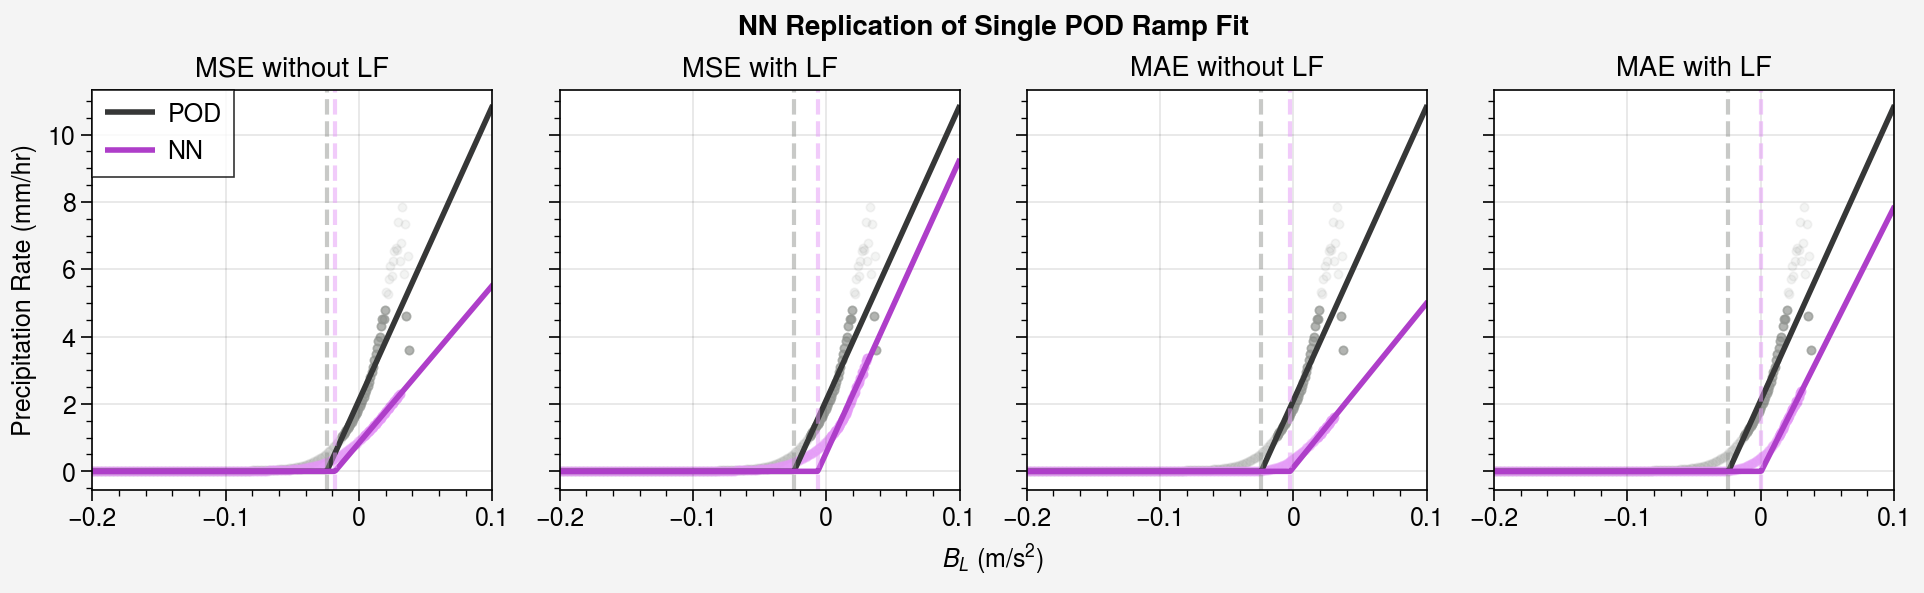

In [32]:
podpooled   = [r for r in PODRUNS if r['mode']=='pooled'][0]
poddata     = np.load(f'{MODELDIRPOD}/pod_{podpooled["run_name"]}.npz')
xbins       = poddata['bincenters']
ymeanspod   = poddata['ymeanpooled']
fitrangepod = poddata['fitrangepooled']
alphapod    = float(poddata['alphapooled'])
blcritpod   = float(poddata['blcritpooled'])


fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=True)
axs.format(suptitle='NN Replication of Single POD Ramp Fit',
           xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.2,0.1),ylabel='Precipitation Rate (mm/hr)')
for i,(runname,data) in enumerate(nnbins.items()):
    bins       = data['pooled']
    ymeansnn   = bins['ymeanpooled']
    fitrangenn = bins['fitrangepooled']
    alphann    = bins['alphapooled']
    blcritnn   = bins['blcritpooled']
    axs[i].scatter(xbins[~fitrangepod],ymeanspod[~fitrangepod],color='gray',marker='.',alpha=0.1)
    axs[i].scatter(xbins[fitrangepod],ymeanspod[fitrangepod],color='gray',marker='.',alpha=0.7)
    axs[i].plot(xbins,alphapod*np.maximum(0,xbins-blcritpod),color='dark gray',linewidth=2,label=f'POD')
    axs[i].axvline(blcritpod,color='gray',alpha=0.5,linestyle='--')
    axs[i].scatter(xbins[~fitrangenn],ymeansnn[~fitrangenn],color='grape3',marker='.',alpha=0.3)
    axs[i].scatter(xbins[fitrangenn],ymeansnn[fitrangenn],color='grape3',marker='.',alpha=0.8)
    axs[i].plot(xbins,alphann*np.maximum(0,xbins-blcritnn),color='grape7',linewidth=2,label=f'NN')
    axs[i].axvline(blcritnn,color='grape3',alpha=0.5,linestyle='--')
    lossstr = data['loss'].upper()
    lfstr   = 'with LF' if data['use_lf'] else 'without LF'
    axs[i].format(title=f'{lossstr} {lfstr}')
axs[0].legend(loc='ul',ncols=1)
pplt.show()

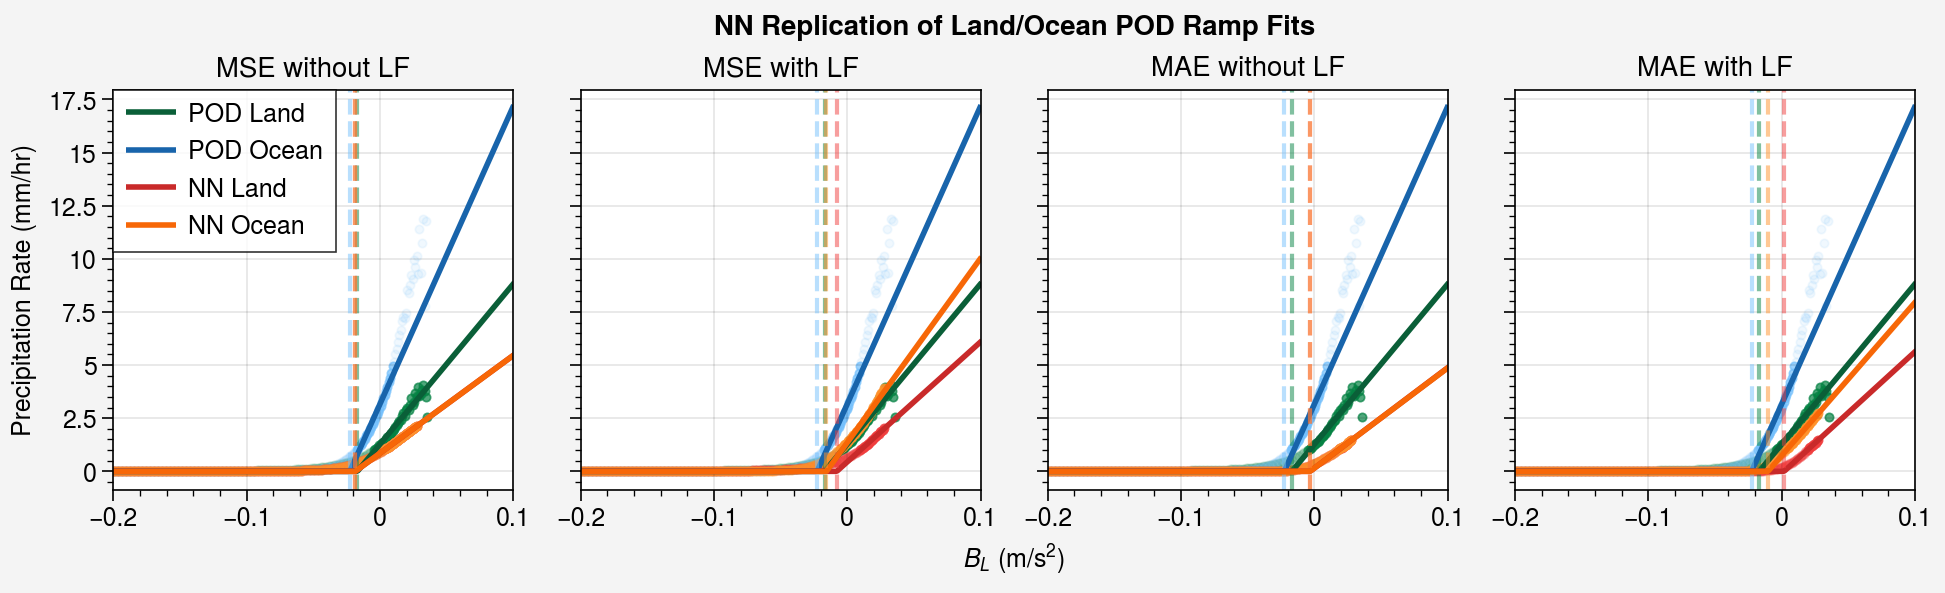

In [33]:
podregional      = [r for r in PODRUNS if r['mode']=='regional'][0]
poddata          = np.load(f'{MODELDIRPOD}/pod_{podregional["run_name"]}.npz')
xbins            = poddata['bincenters']
ymeanslandpod    = poddata['ymeanland']
fitrangelandpod  = poddata['fitrangeland']
alphalandpod     = float(poddata['alphaland'])
blcritlandpod    = float(poddata['blcritland'])
ymeansoceanpod   = poddata['ymeanocean']
fitrangeoceanpod = poddata['fitrangeocean']
alphaoceanpod    = float(poddata['alphaocean'])
blcritoceanpod   = float(poddata['blcritocean'])

fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=True)
axs.format(suptitle='NN Replication of Land/Ocean POD Ramp Fits',
           xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.2,0.1),ylabel='Precipitation Rate (mm/hr)')
for i,(runname,data) in enumerate(nnbins.items()):
    bins            = data['regional']
    ymeanslandnn    = bins['ymeanland']
    fitrangelandnn  = bins['fitrangeland']
    alphalandnn     = bins['alphaland']
    blcritlandnn    = bins['blcritland']
    ymeansoceannn   = bins['ymeanocean']
    fitrangeoceannn = bins['fitrangeocean']
    alphaoceannn    = bins['alphaocean']
    blcritoceannn   = bins['blcritocean']
    axs[i].scatter(xbins[~fitrangelandpod],ymeanslandpod[~fitrangelandpod],color='jungle green',marker='.',alpha=0.1)
    axs[i].scatter(xbins[fitrangelandpod],ymeanslandpod[fitrangelandpod],color='jungle green',marker='.',alpha=0.7)
    axs[i].plot(xbins,alphalandpod*np.maximum(0,xbins-blcritlandpod),color='spruce',linewidth=2,label=f'POD Land')
    axs[i].axvline(blcritlandpod,color='jungle green',alpha=0.5,linestyle='--')
    axs[i].scatter(xbins[~fitrangeoceanpod],ymeansoceanpod[~fitrangeoceanpod],color='blue3',marker='.',alpha=0.1)
    axs[i].scatter(xbins[fitrangeoceanpod],ymeansoceanpod[fitrangeoceanpod],color='blue3',marker='.',alpha=0.7)
    axs[i].plot(xbins,alphaoceanpod*np.maximum(0,xbins-blcritoceanpod),color='blue9',linewidth=2,label=f'POD Ocean')
    axs[i].axvline(blcritoceanpod,color='blue3',alpha=0.5,linestyle='--')
    axs[i].scatter(xbins[~fitrangelandnn],ymeanslandnn[~fitrangelandnn],color='red7',marker='.',alpha=0.3)
    axs[i].scatter(xbins[fitrangelandnn],ymeanslandnn[fitrangelandnn],color='red7',marker='.',alpha=0.8)
    axs[i].plot(xbins,alphalandnn*np.maximum(0,xbins-blcritlandnn),color='red9',linewidth=2,label=f'NN Land')
    axs[i].axvline(blcritlandnn,color='red7',alpha=0.5,linestyle='--')
    axs[i].scatter(xbins[~fitrangeoceannn],ymeansoceannn[~fitrangeoceannn],color='orange5',marker='.',alpha=0.3)
    axs[i].scatter(xbins[fitrangeoceannn],ymeansoceannn[fitrangeoceannn],color='orange5',marker='.',alpha=0.8)
    axs[i].plot(xbins,alphaoceannn*np.maximum(0,xbins-blcritoceannn),color='orange7',linewidth=2,label=f'NN Ocean')
    axs[i].axvline(blcritoceannn,color='orange5',alpha=0.5,linestyle='--')
    lossstr = data['loss'].upper()
    lfstr   = 'with LF' if data['use_lf'] else 'without LF'
    axs[i].format(title=f'{lossstr} {lfstr}')
axs[0].legend(loc='ul',ncols=1)
pplt.show()